# Classifaing both Alzheimer's and Brain Tumor

I will construct a function using four models (two of the models are binary classifiers for Disease-No Disease and Alzheimer's-Brain Tumor, while the other two are categorical classifiers for the severity of Alzheimer's and brain tumor type) to evaluate MRI images and predict the severity of Alzheimer's disease, as well as the type of brain tumor, or lack thereof. The baseline for this application is 37%

In [4]:
import matplotlib.pyplot as plt
from os import listdir
import pandas as pd
import numpy as np
import cv2
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split

import albumentations as A

from tensorflow.math import confusion_matrix
from tensorflow.keras.layers import Dense, Dropout,Flatten, GlobalAveragePooling2D 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetV2S, resnet50
from tensorflow import expand_dims
from tensorflow.image import grayscale_to_rgb
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize

import functions

# For reproducibility
np.random.seed(18)

### Functions

In [2]:
def ald_augmentation(X_train, y_train, binary = False):
    '''
    Augment the data and return initial data combined with augmented prepared for TensorFlow models
    Input:
    X_train - list, preprocessed training images to be augmented.
    y_train - list, labels for images
    binary - bool, controls how to prepare y_train for TensorFlow models, default - False.
    Return:
    X_train with initial images combined with augmented and y_train with labels for all X_train images prepared for TensorFlow models.
    '''
    X_aug = []
    for image in X_train:
        image = transform(image=image)['image']
        image = cv2.resize(image, (image_size, image_size))
        X_aug.append(image)
    # Add augmented data to training set
    X_train = X_train + X_aug
    y_train = y_train + y_train
    # Prepare data for Tensorflow model
    X_train = np.array(X_train, dtype='float32')
    if binary:
        y_train = np.array(y_train, dtype='float32')
    else:
        y_train = to_categorical(y_train, num_classes=3, dtype='float32')
    return X_train, y_train

In [3]:
def load_img_from_dir_cat(path, augmentation = False):
    '''
    Load images from the path and prepare for the TensorFlow model
    Input: 
    path - str, the path to the images folder
    augmentation - bool, if True augmentation is applied on training data, default - False.
    Return: 
    For Training set - return  X_train, X_val, y_train, y_val (arrays, ready for TensorFlow models), with X_train and y_train augmented, if specified.
    For Test set - return X_test, y_test (arrays, ready for TensorFlow models)   
    '''
    X = []
    y = []

    for num_label, label in enumerate(listdir(path)):
        # Skip No disease folders
        if label in ('NonDemented', 'no_tumor'):
            continue
        else:
            # Change each image and append to X and y
            for image_file in listdir(f'{path}/{label}'):
                 if '.jpg' in image_file:
                    img = load_img(f'{path}/{label}/{image_file}', target_size=(image_size, image_size), color_mode='grayscale')
                    img = expand_dims(img, -1)
                    # Make image RGB for pre-trained models
                    img = grayscale_to_rgb(img)
                    img_arr = img_to_array(img) 
                    X.append(img_arr)                
                    if num_label == 3:
                        num_label = 2
                    y.append(num_label) 
                    # For training the model
    if 'train' in path:
        X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=18, stratify=y) 
        
        # Change for TensorFlow models
        X_val = np.array(X_val, dtype='float32')        
        y_val = to_categorical(y_val, num_classes=3, dtype='float32')
        
        # Apply augmentation on trainig set 
        if augmentation:
            X_train, y_train = ald_augmentation(X_train, y_train)
        
        else:
            X_train = np.array(X_train, dtype='float32')
            y_train = to_categorical(y_train, num_classes=3, dtype='float32')

        return X_train, X_val, y_train, y_val
    # For testing
    else:
        X_test = np.array(X, dtype='float32')
        y_test = to_categorical(y, num_classes=3, dtype='float32')
        return X_test, y_test

In [4]:
def load_img_from_dir_binary(path):
    '''
    Load images for binary model Disease or No Disease
    Input: 
    path - str, the path to the images folder
    Return: 
    X - list, images converted to RGB and array
    y - list, lables for images (0 - No Disease, 1 - Disease)
    '''
    X = []
    y = []

    for label in listdir(path):
        # Change each image and append to X and y
        for image_file in listdir(f'{path}/{label}'):
             if '.jpg' in image_file:
                # target_size automatically resizes each img on import
                img = load_img(f'{path}/{label}/{image_file}', target_size=(image_size, image_size), color_mode='grayscale')
                img = expand_dims(img, -1)
                # Make image RGB for pre-trained models
                img = grayscale_to_rgb(img)
                img_arr = img_to_array(img) 
                X.append(img_arr)
                if label in ('NonDemented', 'no_tumor'):
                    y.append(0)
                else:
                    y.append(1)
    return X, y

In [5]:
def al_bt_load_img_from_dir_binary(path):
    '''
    Load images for binary model Alzheimer\'s or Brain Tumor
    Input: 
    path - str, the path to the images folder
    Return: 
    X - list, images converted to RGB and array
    y - list, lables for images (0 - Alzheimer, 1 - Brain Tumor)
    '''
    X = []
    y = []

    for label in listdir(path):
        # Skip No disease folders
        if label not in ('NonDemented', 'no_tumor'):
            # Change each image and append to X and y
            for image_file in listdir(f'{path}/{label}'):
                 if '.jpg' in image_file:
                    img = load_img(f'{path}/{label}/{image_file}', target_size=(image_size, image_size), color_mode='grayscale')
                    img = expand_dims(img, -1)
                    # Make image RGB for pre-trained models
                    img = grayscale_to_rgb(img)
                    img_arr = img_to_array(img) 
                    X.append(img_arr)
                    if 'alzheimer' in path:
                        y.append(0)
                    else:
                        y.append(1)
    return X, y

In [6]:
def combine_images_from_two_path_binary(path1, path2, function = load_img_from_dir_binary, augmentation = False):
    '''
    Combine images from two paths and prepare for TensorFlow models
    Input: 
    path1 - str, the path to the first images folder
    path2 - str, the path to the second images folder
    function - str, name of the function to read the images from the path (different for Disease-No Disease and Alzheimer-Brain Tumor), default - load_img_from_dir_binary (for Disease-No Disease)
    augmentation - bool, if True augmentation is applied on training data, default - False.
    Return: 
    For Training set - return  X_train, X_val, y_train, y_val (arrays, ready for TensorFlow models), with X_train and y_train augmented, if specified.
    For Test set - return X_test, y_test (arrays, ready for TensorFlow models)
    '''
    X_1, y_1 = function(path1)
    X_2, y_2 = function(path2)
    
    X = X_1 + X_2
    y = y_1 + y_2
    if 'train' in path1:
        X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=18, stratify=y) 
        
        X_val = np.array(X_val, dtype='float32')
        y_val = np.array(y_val, dtype='float32')
        # Apply augmentation on trainig set 
        if augmentation:
            X_train, y_train = ald_augmentation(X_train, y_train, binary = True)
        else:
            X_train = np.array(X_train, dtype='float32')
            y_train = np.array(y_train, dtype='float32')
        return X_train, X_val, y_train, y_val
    else:
        X_test = np.array(X, dtype='float32')
        y_test = np.array(y, dtype='float32')
        return X_test, y_test

In [9]:
# Set image size
image_size = 240

# Set Early stopping
es = EarlyStopping(patience = 5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [10]:
# Path to Alzheimer's data
al_path_train = '../data/alzheimer/train'
al_path_test = '../data/alzheimer/test'

# Path to Brain Tumor data
bt_path_train = '../data/brain_tumor/train'
bt_path_test = '../data/brain_tumor/test'

---

## Make Binary data Disease - No disease. No augmentation
Combine datasets and make binary data - disease - 1, no disease - 0. We need to catch as many disease cases as possible. For this model,  I will use Recall as a metric instead of Accuracy to reduce the number of disease images classified as no disease. 

In [25]:
def evaluation_plots(history, name_for_title, metric = 'recall', val_metric = 'val_recall'):
    '''
    Plot loss and Recall over epochs
    Input: 
    history - history of the fitted model
    name_for_title - string, the name for the title of the plot
    metric - string, name of the metric used to evaluate the model during fit
    val_metric - string, name of the metric used to evaluate the model on the validation set during fit
    Output: Side-by-side plots for Categorical Crossentropy and Recall
    '''
    # Plot Categorical Crossentropy
    fig, ax = plt.subplots(1,2, figsize=(14,7))
    fig.suptitle(name_for_title, fontsize=20)
    ax[0].plot(history.history['loss'], label='Train', color = 'yellowgreen')
    ax[0].plot(history.history['val_loss'], label = 'Test', color = 'maroon')
    ax[0].set_title('Categorical Crossentropy', size = 20)
    ax[0].set_xlabel('# Epochs', size = 20)
    if len(history.history['loss']) < 15:
        ax[0].set_xticks(range(len(history.history['loss'])))
    ax[0].legend()
    
    # Plot Accuracy
    ax[1].plot(history.history[metric], label='Train', color = 'yellowgreen')
    ax[1].plot(history.history[val_metric], label = 'Test', color = 'maroon')
    ax[1].set_title('Recall', size = 20)
    ax[1].set_xlabel('# Epochs', size = 20)
    if len(history.history[metric]) < 15:
        ax[1].set_xticks(range(len(history.history[metric])))
    ax[1].legend();

In [16]:
def recall_conf_matrix(model, X, y, class_names_list):
    '''
    Evaluate the model
    Input:
    model - TensorFlow model
    X - array, images converted for TensorFlow models, default - None
    y - array, labels converted for TensorFlow model, default - None
    class_names_list - list, names of the classes, for data split to X and y, default - None
    binary - bool, controls the handling of y and predictions, default - False
    Output:
    Prints Accuracy of the model on a given set of data
    Plots Confusion matrics for a given set of data
    '''
    # Generate Confusion Matrix
    predictions = np.array([])
   
    predictions = (model.predict(X, verbose = False) > 0.5).astype("int32")
      
    cm = confusion_matrix(labels=y, predictions=predictions).numpy()
    # Print Accuracy score
    acc = round(accuracy_score(y, predictions), 4)
    print(f'Accuracy_score: {acc} \n') 
    # Print Recall
    recall = round(recall_score(y, predictions), 4)
    print(f'Recall_score: {recall} \n') 
    # Plot the confusion matrix
    fig, ax = plot_confusion_matrix(cm, class_names=class_names_list)    

In [9]:
X_train, X_val, y_train, y_val = combine_images_from_two_path_binary(al_path_train, bt_path_train)
X_train.shape, y_train.shape

((5993, 240, 240, 3), (5993,))

In [10]:
X_test, y_test = combine_images_from_two_path_binary(al_path_test, bt_path_test)

In [49]:
rn_model_bi = resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classifier_activation="sigmoid"
)

for layer in rn_model_bi.layers:
    layer.trainable = False

In [12]:
model = Sequential()

model.add(rn_model_bi)
model.add(Flatten())

#Just use a single output layer
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[Recall()])

h = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
188/188 [==============================] - 276s 1s/step - loss: 1.4739 - recall: 0.8268 - val_loss: 0.9495 - val_recall: 0.7585 - lr: 0.0010
Epoch 2/30
188/188 [==============================] - 276s 1s/step - loss: 0.4815 - recall: 0.9211 - val_loss: 0.4380 - val_recall: 0.9611 - lr: 0.0010
Epoch 3/30
188/188 [==============================] - 280s 1s/step - loss: 0.1807 - recall: 0.9587 - val_loss: 0.7051 - val_recall: 0.9944 - lr: 0.0010
Epoch 4/30
188/188 [==============================] - 281s 1s/step - loss: 0.3582 - recall: 0.9436 - val_loss: 1.4972 - val_recall: 0.6847 - lr: 0.0010
Epoch 5/30
188/188 [==============================] - 278s 1s/step - loss: 0.0645 - recall: 0.9833 - val_loss: 0.4637 - val_recall: 0.9857 - lr: 0.0010
Epoch 6/30
188/188 [==============================] - 272s 1s/step - loss: 0.2150 - recall: 0.9658 - val_loss: 1.1374 - val_recall: 0.8078 - lr: 0.0010
Epoch 7/30
188/188 [==============================] - 277s 1s/step - loss: 0.1941 - reca

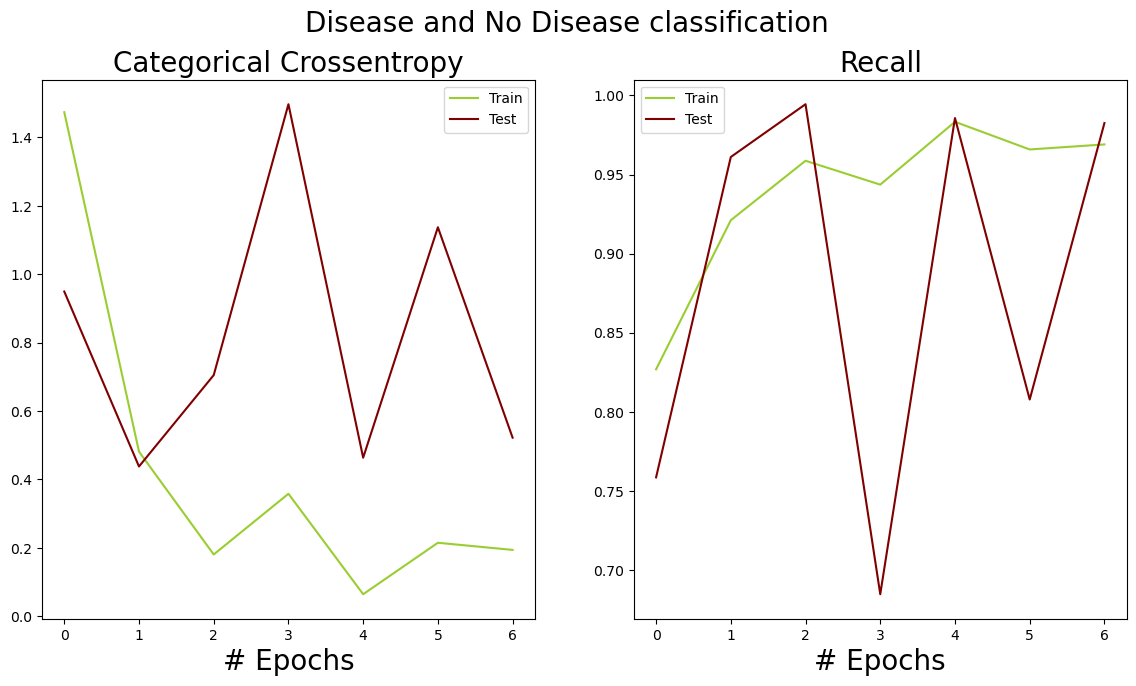

In [15]:
# Plot Crossentropy and Accuracy by epoch
evaluation_plots(h, 'Disease and No Disease classification')

Accuracy_score: 0.9204 

Recall_score: 0.9611 



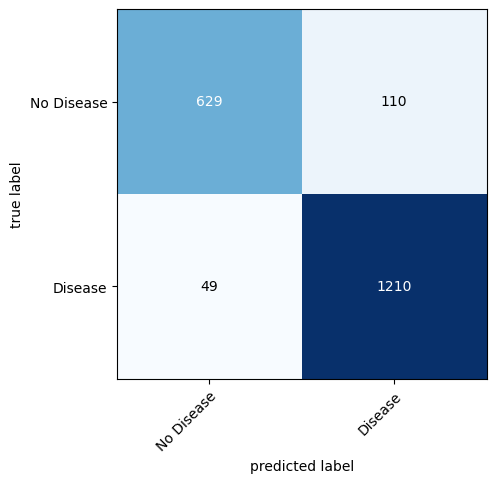

In [17]:
# Plot Confusion Matrix 
recall_conf_matrix(model, X=X_val, y=y_val, class_names_list =  ['No Disease', 'Disease'])

Accuracy_score: 0.7687 

Recall_score: 0.7274 



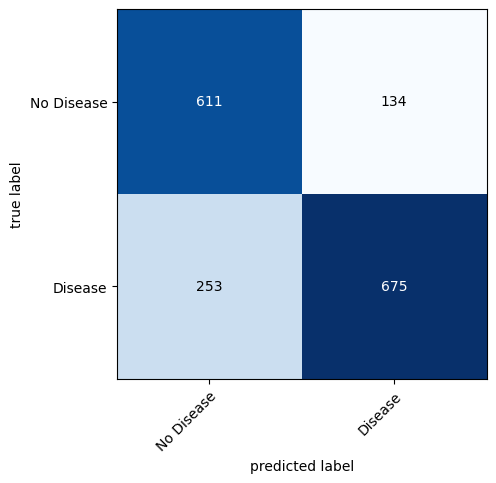

In [18]:
# Plot Confusion Matrix 
recall_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['No Disease', 'Disease'])

In [22]:
# model.save('../models/disease_no_disease_recall.hdf5') the models are too big for git (over 50 MB limit) you can see them in https://drive.google.com/drive/folders/1c6tiwYgU2JKSHqd8JnuYHc5rYQC3wRYI?usp=share_link

This model is overfitting, it gives 77% accuracy (73% recall) on test set and 92% (96% recall) on validation set. I will try to combat overfitting by applying augmentation.

---

## Make Binary data Disease - No disease - with Augmentation
Combine datasets and make binary data - disease - 1, no disease - 0

In [19]:
# Augmentation transformations using Albumentations with best results for Disease or No Disease classification.
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(p=0.25),
    A.Rotate(limit=10, p=0.5)    
])

In [20]:
X_train_aug, X_val, y_train_aug, y_val = combine_images_from_two_path_binary(al_path_train, bt_path_train, augmentation = True)
X_train_aug.shape, y_train_aug.shape

((11986, 240, 240, 3), (11986,))

In [21]:
# X_test, y_test and ResNet50 stay the same
model_aug = Sequential()

model_aug.add(rn_model_bi)
model_aug.add(Flatten())

#Just use a single output layer
model_aug.add(Dense(1, activation='sigmoid'))

# Compile
model_aug.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[Recall()])

h_aug = model_aug.fit(X_train_aug, y_train_aug, validation_data = (X_val, y_val), epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
375/375 [==============================] - 476s 1s/step - loss: 1.6880 - recall_1: 0.8221 - val_loss: 0.5855 - val_recall_1: 0.9063 - lr: 0.0010
Epoch 2/30
375/375 [==============================] - 472s 1s/step - loss: 0.6370 - recall_1: 0.8983 - val_loss: 0.6178 - val_recall_1: 0.8499 - lr: 0.0010
Epoch 3/30
375/375 [==============================] - 478s 1s/step - loss: 0.7469 - recall_1: 0.8982 - val_loss: 1.5510 - val_recall_1: 0.9976 - lr: 0.0010
Epoch 4/30
375/375 [==============================] - 478s 1s/step - loss: 0.3624 - recall_1: 0.9378 - val_loss: 0.5784 - val_recall_1: 0.9793 - lr: 0.0010
Epoch 5/30
375/375 [==============================] - 474s 1s/step - loss: 0.4000 - recall_1: 0.9432 - val_loss: 0.5011 - val_recall_1: 0.9754 - lr: 0.0010
Epoch 6/30
375/375 [==============================] - 481s 1s/step - loss: 0.3855 - recall_1: 0.9374 - val_loss: 1.0838 - val_recall_1: 0.9929 - lr: 0.0010
Epoch 7/30
375/375 [==============================] - 487s 1s/st

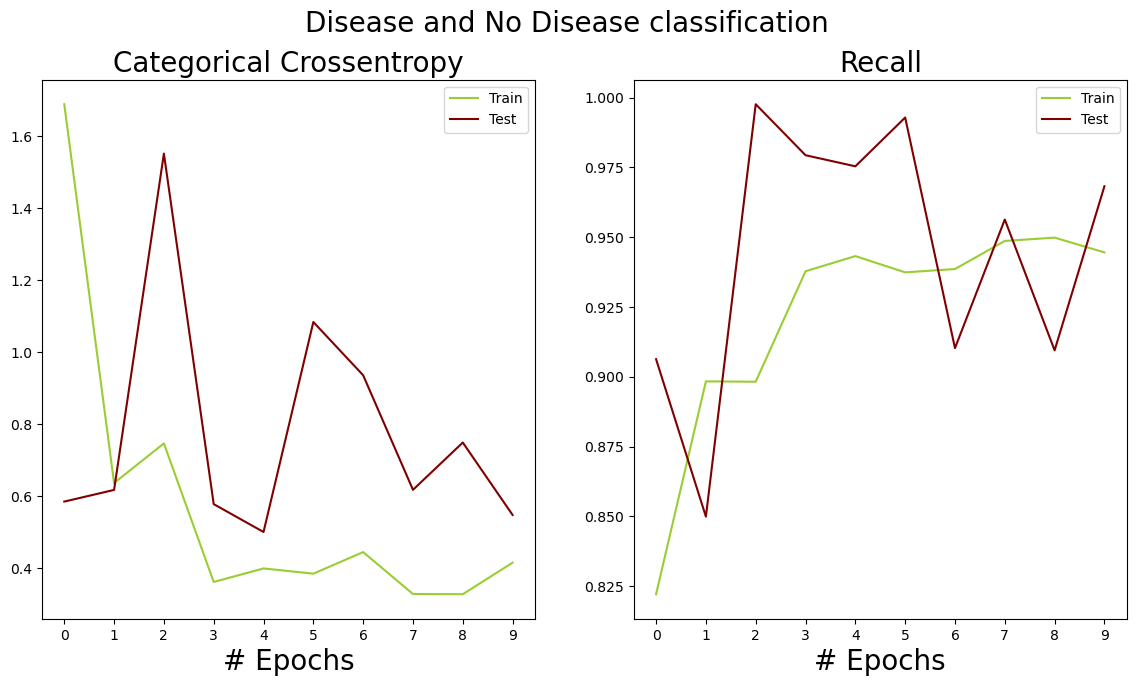

In [26]:
# Plot Crossentropy and Accuracy by epoch
evaluation_plots(h_aug, 'Disease and No Disease classification', metric = 'recall_1', val_metric = 'val_recall_1')

Accuracy_score: 0.9404 

Recall_score: 0.9754 



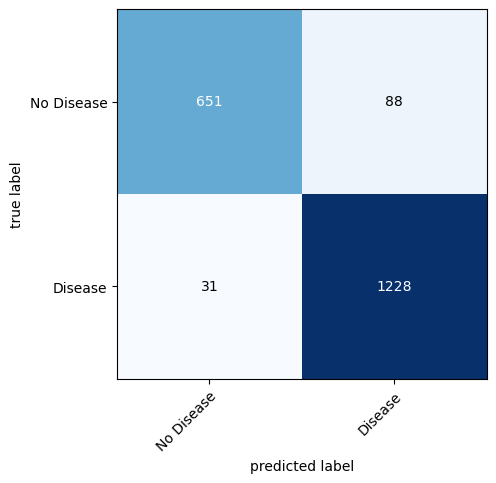

In [27]:
# Plot Confusion Matrix 
recall_conf_matrix(model_aug, X=X_val, y=y_val, class_names_list =  ['No Disease', 'Disease'])

Accuracy_score: 0.7998 

Recall_score: 0.8384 



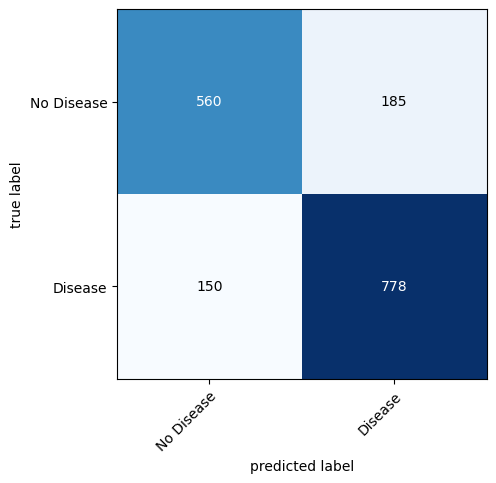

In [38]:
# Plot Confusion Matrix 
recall_conf_matrix(model_aug, X=X_test, y=y_test, class_names_list =  ['No Disease', 'Disease'])

In [39]:
# model_aug.save('../models/disease_no_disease_aug_recall.hdf5') the models are too big for git (over 50 MB limit) you can see them in https://drive.google.com/drive/folders/1c6tiwYgU2JKSHqd8JnuYHc5rYQC3wRYI?usp=share_link

Augmentation improved accuracy and recall. Without Augmentation 77% (recall 72%) and best after tuning the probabilities 80% (recall 84%). Recall was improved considerably with augmentation. False Negatives (classifying no disease instead of disease) went down from 253 to 150 images.

---

## Make Binary data Alzheimer's - Brain tumor. 
Combine datasets, ignoring No disease images and make binary data - Alzheimer's  - 0, Brain tumor - 1

In [53]:
X_train_al_bt, X_val_al_bt, y_train_al_bt, y_val_al_bt = combine_images_from_two_path_binary(al_path_train, bt_path_train, function = al_bt_load_img_from_dir_binary)
X_train_al_bt.shape, y_train_al_bt.shape

((3777, 240, 240, 3), (3777,))

In [ ]:
X_test_al_bt, y_test_al_bt = combine_images_from_two_path_binary(al_path_test, bt_path_test, function = al_bt_load_img_from_dir_binary)

In [55]:
effnet_bi = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classifier_activation="sigmoid",
    include_preprocessing=True,
)

# Freeze last 5 layers
for layer in effnet_bi.layers[:-5]:
    layer.trainable = False

In [56]:
model_al_bt = Sequential()

model_al_bt.add(effnet_bi)
model_al_bt.add(GlobalAveragePooling2D())


#Just use a single output layer
model_al_bt.add(Dense(1, activation='sigmoid'))

# Compile
model_al_bt.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

h_al_bt = model_al_bt.fit(X_train_al_bt, y_train_al_bt, validation_data = (X_val_al_bt, y_val_al_bt), epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
119/119 [==============================] - 243s 2s/step - loss: 0.1225 - accuracy: 0.9550 - val_loss: 0.0294 - val_accuracy: 0.9889 - lr: 0.0010
Epoch 2/30
119/119 [==============================] - 251s 2s/step - loss: 0.0528 - accuracy: 0.9780 - val_loss: 0.0142 - val_accuracy: 0.9952 - lr: 0.0010
Epoch 3/30
119/119 [==============================] - 234s 2s/step - loss: 0.0370 - accuracy: 0.9860 - val_loss: 0.0130 - val_accuracy: 0.9952 - lr: 0.0010
Epoch 4/30
119/119 [==============================] - 225s 2s/step - loss: 0.0346 - accuracy: 0.9860 - val_loss: 0.0073 - val_accuracy: 0.9968 - lr: 0.0010
Epoch 5/30
119/119 [==============================] - 231s 2s/step - loss: 0.0349 - accuracy: 0.9846 - val_loss: 0.0096 - val_accuracy: 0.9968 - lr: 0.0010
Epoch 6/30
119/119 [==============================] - 225s 2s/step - loss: 0.0331 - accuracy: 0.9860 - val_loss: 0.0086 - val_accuracy: 0.9968 - lr: 0.0010
Epoch 7/30
119/119 [==============================] - 223s 2s/st

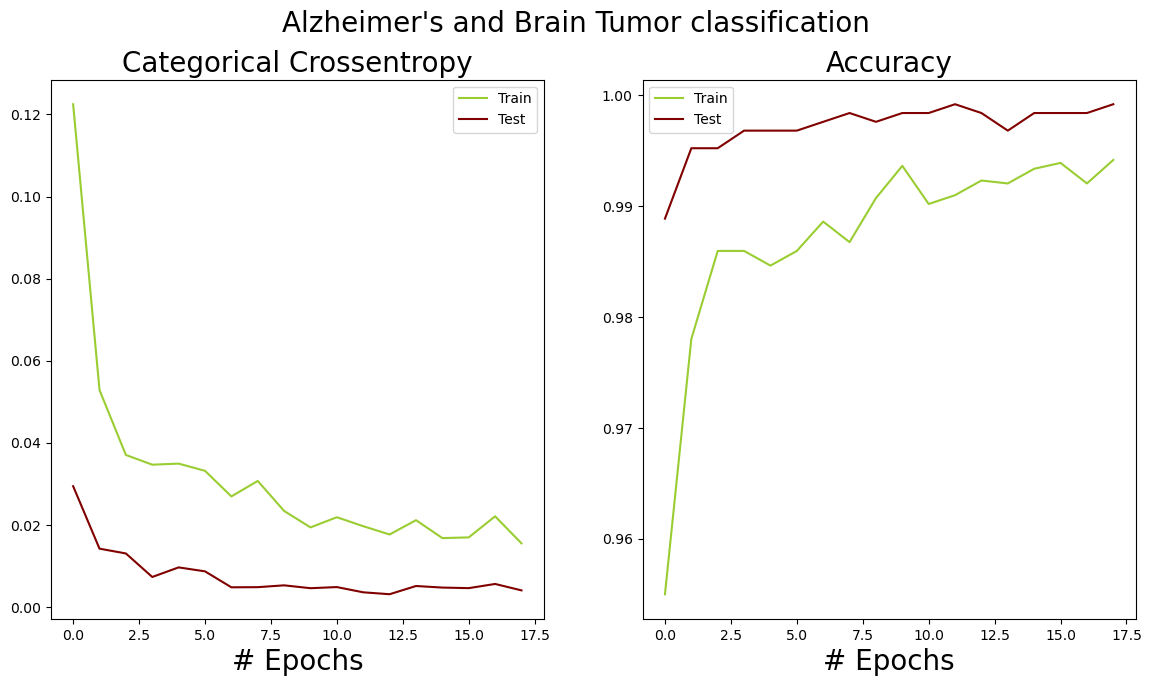

In [57]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_al_bt, 'Alzheimer\'s and Brain Tumor classification')

Accuracy_score: 0.9984 



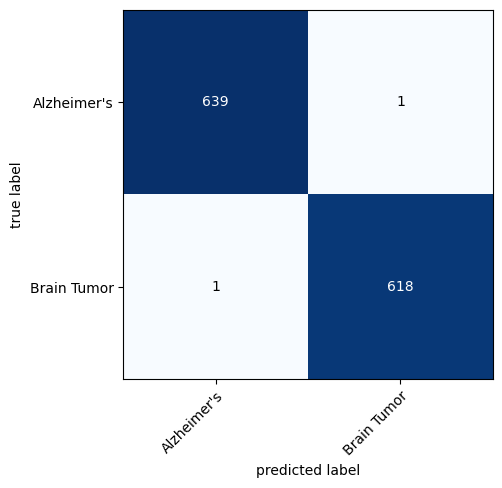

In [58]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al_bt, X=X_val_al_bt, y=y_val_al_bt, class_names_list =  ['Alzheimer\'s', 'Brain Tumor'], binary = True)

Accuracy_score: 0.9989 



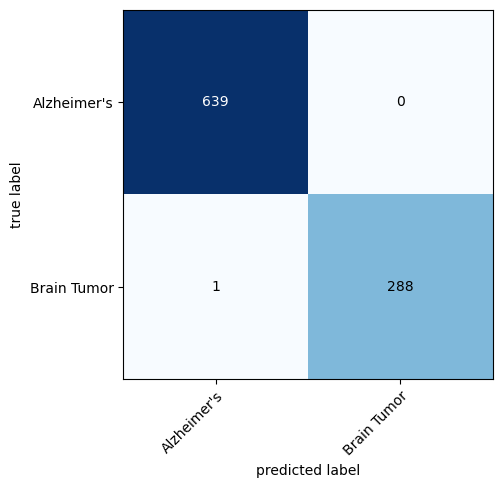

In [59]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al_bt, X=X_test_al_bt, y=y_test_al_bt, class_names_list =  ['Alzheimer\'s', 'Brain Tumor'], binary = True)

In [72]:
# model_al_bt.save('../models/al_bt.hdf5')  the models are too big for git (over 50 MB limit) you can see them in https://drive.google.com/drive/folders/1c6tiwYgU2JKSHqd8JnuYHc5rYQC3wRYI?usp=share_link

This model performs great. Only one MRI image was miscassified. I do not need to augment data for this model.

---

## Predict Sevetiry of Alzeimer's or Type of Brain Tumor

### Sevetiry of Alzeimer's - No Augmentation

In [61]:
X_train_al, X_val_al, y_train_al, y_val_al = load_img_from_dir_cat(al_path_train)
X_train_al.shape, y_train_al.shape

((1920, 240, 240, 3), (1920, 3))

In [9]:
X_test_al, y_test_al = load_img_from_dir_cat(al_path_test)

In [10]:
rn_model = resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=3,
    classifier_activation="softmax"
)

In [11]:
for layer in rn_model.layers:
    layer.trainable = False

In [65]:
model_al = Sequential()

model_al.add(rn_model)
model_al.add(Flatten())

#Just use a single output layer
model_al.add(Dense(3, activation='softmax'))

# Compile
model_al.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_al = model_al.fit(X_train_al, y_train_al, validation_data = (X_val_al, y_val_al), epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
60/60 [==============================] - 97s 2s/step - loss: 5.5810 - accuracy: 0.6969 - val_loss: 0.7421 - val_accuracy: 0.8846 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 95s 2s/step - loss: 0.2064 - accuracy: 0.9453 - val_loss: 0.4199 - val_accuracy: 0.9002 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 96s 2s/step - loss: 0.2485 - accuracy: 0.9354 - val_loss: 0.5069 - val_accuracy: 0.9080 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 94s 2s/step - loss: 0.1424 - accuracy: 0.9719 - val_loss: 0.4738 - val_accuracy: 0.8830 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 95s 2s/step - loss: 0.1091 - accuracy: 0.9698 - val_loss: 0.5678 - val_accuracy: 0.9111 - lr: 0.0010
Epoch 6/30
60/60 [==============================] - 94s 2s/step - loss: 0.2856 - accuracy: 0.9401 - val_loss: 0.3927 - val_accuracy: 0.9220 - lr: 0.0010
Epoch 7/30
60/60 [==============================] - 97s 2s/step - loss: 0.0449 - a

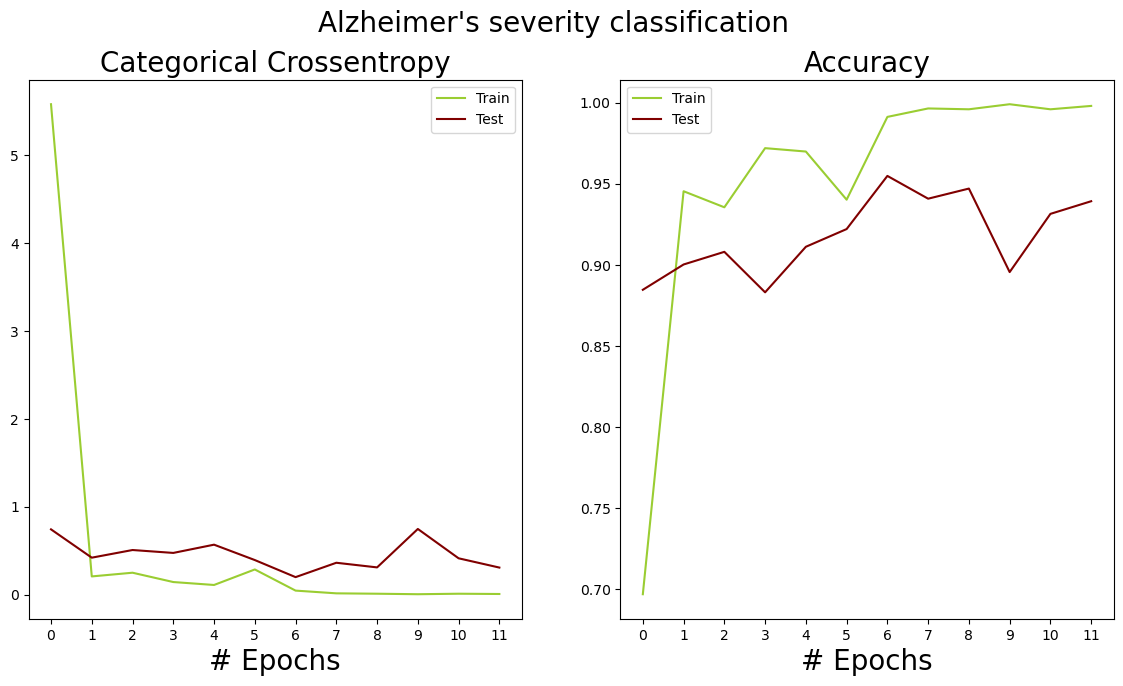

In [66]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_al, 'Alzheimer\'s severity classification')

Accuracy_score: 0.9548 



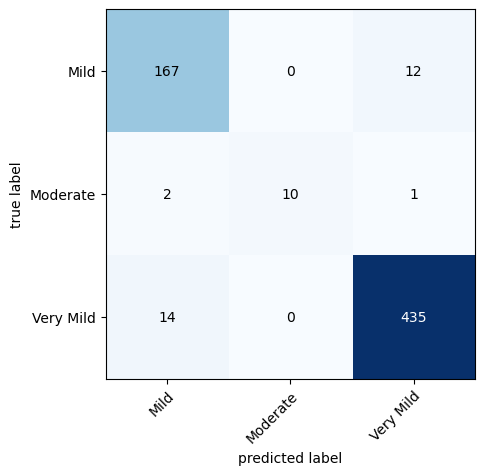

In [67]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al, X=X_val_al, y=y_val_al, class_names_list = ['Mild', 'Moderate', 'Very Mild'])

Accuracy_score: 0.7731 



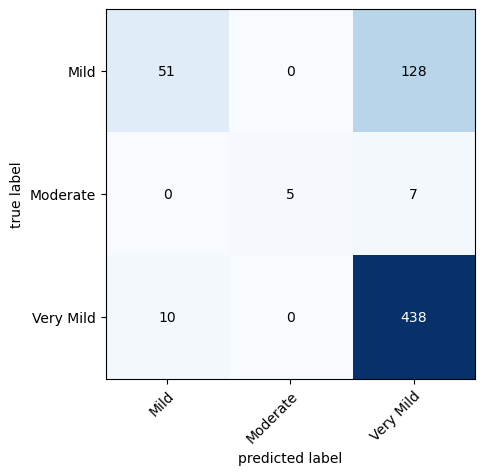

In [68]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al, X=X_test_al, y=y_test_al, class_names_list = ['Mild', 'Moderate', 'Very Mild'])

In [69]:
# model_al.save('../models/model_al.hdf5') the models are too big for git (over 50 MB limit) you can see them in https://drive.google.com/drive/folders/1c6tiwYgU2JKSHqd8JnuYHc5rYQC3wRYI?usp=share_link

The model is overfitting with 95% on validation set used during model training and 77% on test set. 

---

### Sevetiry of Alzeimer's - with Augmentation

In [106]:
# Augmentation transformations using Albumentations with best results for Alzheimer's disease classification (the same as for Disease or No Disease).
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(p=0.25),
    A.Rotate(limit=10, p=0.5)    
])

In [70]:
X_train_al_aug, X_val_al, y_train_al_aug, y_val_al = load_img_from_dir_cat(al_path_train, augmentation = True)
X_train_al_aug.shape, y_train_al_aug.shape

((3840, 240, 240, 3), (3840, 3))

In [71]:
# X_test, y_test and ResNet50 stay the same
model_al_aug = Sequential()

model_al_aug.add(rn_model)
model_al_aug.add(Flatten())

#Just use a single output layer
model_al_aug.add(Dense(3, activation='softmax'))

# Compile
model_al_aug.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_al_aug = model_al_aug.fit(X_train_al_aug, y_train_al_aug, validation_data = (X_val_al, y_val_al), epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
120/120 [==============================] - 160s 1s/step - loss: 4.4093 - accuracy: 0.7042 - val_loss: 1.1109 - val_accuracy: 0.7941 - lr: 0.0010
Epoch 2/30
120/120 [==============================] - 162s 1s/step - loss: 1.2380 - accuracy: 0.8570 - val_loss: 5.5814 - val_accuracy: 0.7239 - lr: 0.0010
Epoch 3/30
120/120 [==============================] - 164s 1s/step - loss: 0.9118 - accuracy: 0.8966 - val_loss: 1.0677 - val_accuracy: 0.8175 - lr: 0.0010
Epoch 4/30
120/120 [==============================] - 161s 1s/step - loss: 0.5821 - accuracy: 0.9234 - val_loss: 0.4304 - val_accuracy: 0.9329 - lr: 0.0010
Epoch 5/30
120/120 [==============================] - 158s 1s/step - loss: 0.6455 - accuracy: 0.9174 - val_loss: 0.7071 - val_accuracy: 0.9220 - lr: 0.0010
Epoch 6/30
120/120 [==============================] - 166s 1s/step - loss: 0.5773 - accuracy: 0.9294 - val_loss: 1.0545 - val_accuracy: 0.8440 - lr: 0.0010
Epoch 7/30
120/120 [==============================] - 168s 1s/st

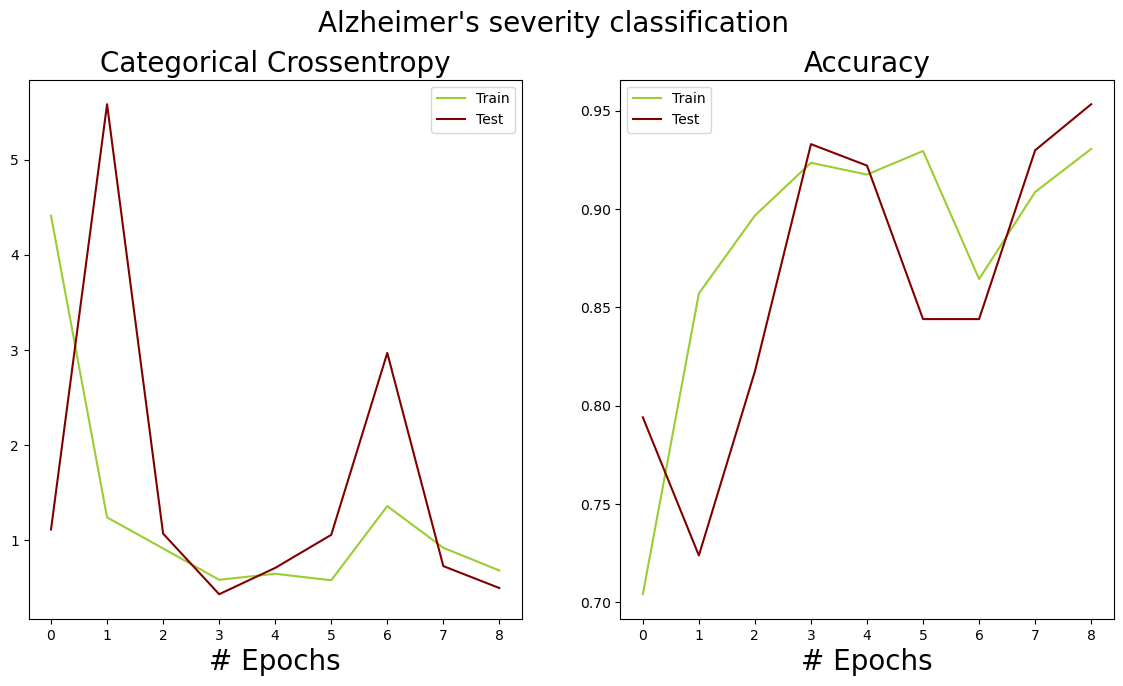

In [72]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_al_aug, 'Alzheimer\'s severity classification')

Accuracy_score: 0.9329 



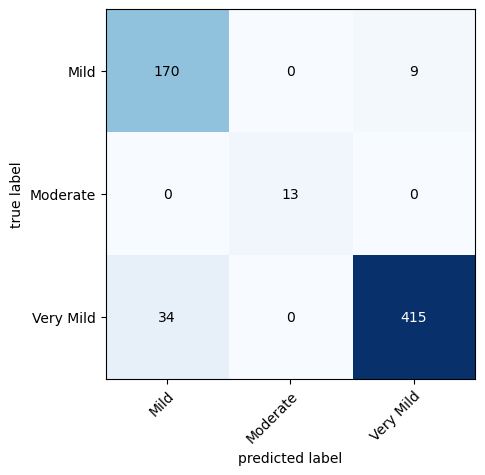

In [73]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al_aug, X=X_val_al, y=y_val_al, class_names_list = ['Mild', 'Moderate', 'Very Mild'])

Accuracy_score: 0.7872 



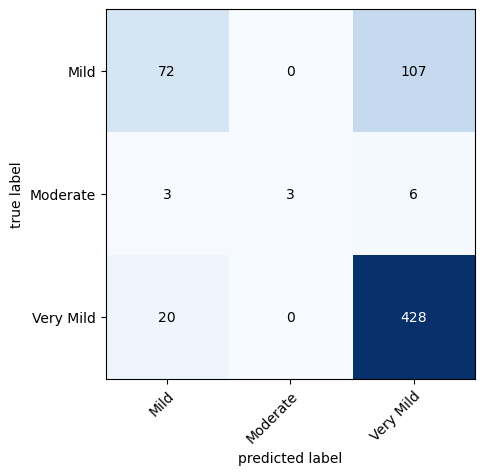

In [74]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al_aug, X=X_test_al, y=y_test_al, class_names_list = ['Mild', 'Moderate', 'Very Mild'])

In [75]:
# model_al_aug.save('../models/model_al_aug_2.hdf5') the models are too big for git (over 50 MB limit) you can see them in https://drive.google.com/drive/folders/1c6tiwYgU2JKSHqd8JnuYHc5rYQC3wRYI?usp=share_link

Augmentation improved the model accuracy from 77% to 79%

---

### Type of Brain Tumor - No Augmentation

In [70]:
X_train_bt, X_val_bt, y_train_bt, y_val_bt = load_img_from_dir_cat(bt_path_train)
X_train_bt.shape, y_train_bt.shape

((1856, 240, 240, 3), (1856, 3))

In [97]:
X_test_bt, y_test_bt = load_img_from_dir_cat(bt_path_test)

In [98]:
effnet = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=3,
    classifier_activation="softmax",
    include_preprocessing=True,
)
# Freeze last 5 layers
for layer in effnet.layers[:-5]:
    layer.trainable = False

In [73]:
model_bt = Sequential()

model_bt.add(effnet)
model_bt.add(GlobalAveragePooling2D())
model_bt.add(Dropout(.2))

#Just use a single output layer
model_bt.add(Dense(3, activation='softmax'))

# Compile
model_bt.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_bt = model_bt.fit(X_train_bt, y_train_bt, validation_data = (X_val_bt, y_val_bt), epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
58/58 [==============================] - 119s 2s/step - loss: 0.5363 - accuracy: 0.7796 - val_loss: 0.3729 - val_accuracy: 0.8498 - lr: 0.0010
Epoch 2/30
58/58 [==============================] - 112s 2s/step - loss: 0.3549 - accuracy: 0.8578 - val_loss: 0.3309 - val_accuracy: 0.8643 - lr: 0.0010
Epoch 3/30
58/58 [==============================] - 110s 2s/step - loss: 0.2980 - accuracy: 0.8885 - val_loss: 0.2769 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 4/30
58/58 [==============================] - 122s 2s/step - loss: 0.2509 - accuracy: 0.9106 - val_loss: 0.2489 - val_accuracy: 0.9095 - lr: 0.0010
Epoch 5/30
58/58 [==============================] - 108s 2s/step - loss: 0.2064 - accuracy: 0.9283 - val_loss: 0.2019 - val_accuracy: 0.9257 - lr: 0.0010
Epoch 6/30
58/58 [==============================] - 104s 2s/step - loss: 0.1841 - accuracy: 0.9359 - val_loss: 0.1981 - val_accuracy: 0.9338 - lr: 0.0010
Epoch 7/30
58/58 [==============================] - 171s 3s/step - loss: 0.1

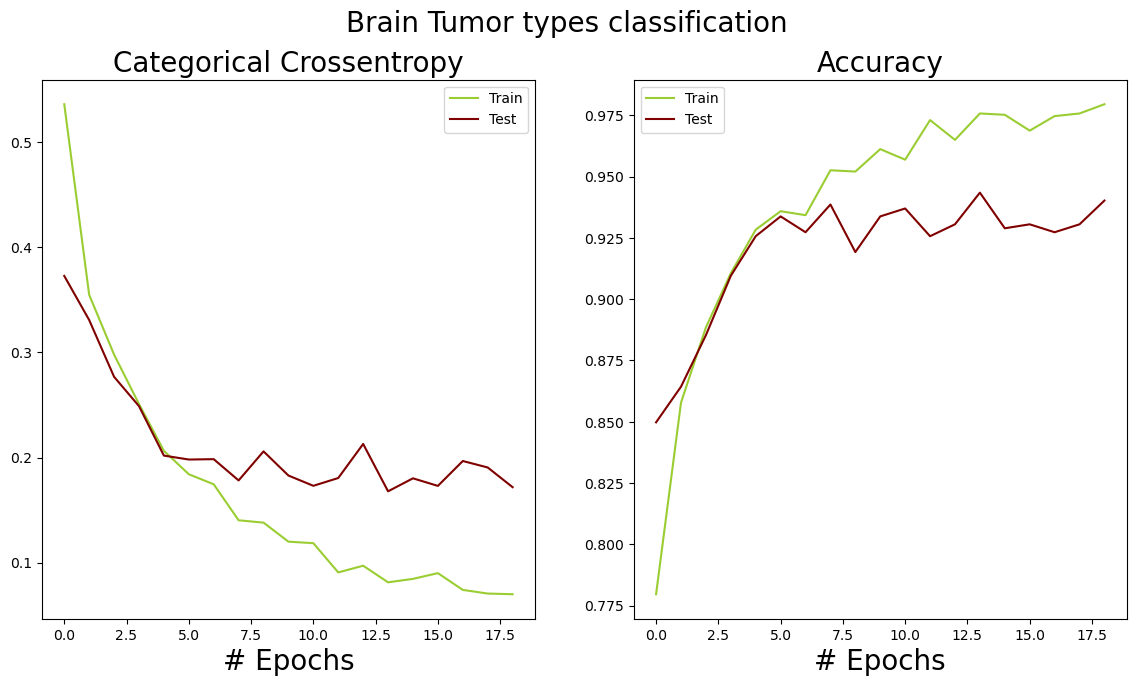

In [74]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_bt, 'Brain Tumor types classification')

Accuracy_score: 0.9435 



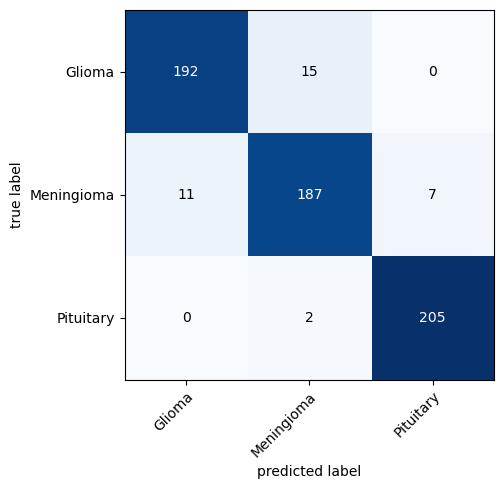

In [75]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_bt, X=X_val_bt, y=y_val_bt, class_names_list = ['Glioma', 'Meningioma', 'Pituitary'])

Accuracy_score: 0.7093 



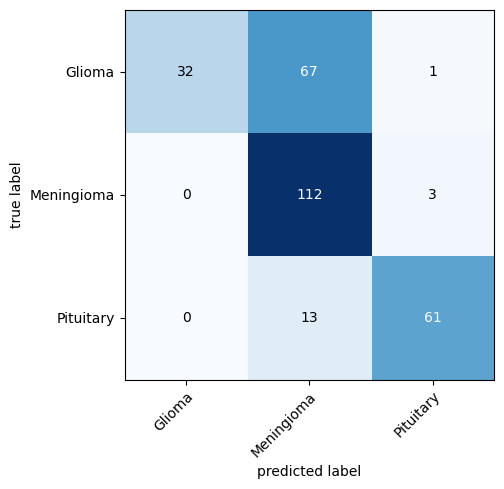

In [76]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_bt, X=X_test_bt, y=y_test_bt, class_names_list = ['Glioma', 'Meningioma', 'Pituitary'])

In [78]:
# model_bt.save('../models/model_bt.hdf5') the models are too big for git (over 50 MB limit) you can see them in https://drive.google.com/drive/folders/1c6tiwYgU2JKSHqd8JnuYHc5rYQC3wRYI?usp=share_link

The model struggles to identify Glioma. It is overfitting with 94% on the Validation set and 70% accuracy on the test set.

---

### Type of Brain Tumor - With Augmentation

In [ ]:
# The best augmentation from the previous notebook.
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(p=0.5),
    A.Rotate(limit=10, p=0.5)    
])

In [56]:
X_train_bt_aug, X_val_bt, y_train_bt_aug, y_val_bt = load_img_from_dir_cat(bt_path_train, augmentation = True)
X_train_bt_aug.shape, y_train_bt_aug.shape

((3712, 240, 240, 3), (3712, 3))

In [57]:
# X_test_bt, y_test_bt and EfficientNetV2S stay the same

model_bt_aug = Sequential()

model_bt_aug.add(effnet)
model_bt_aug.add(GlobalAveragePooling2D())
model_bt_aug.add(Dropout(.2))

#Just use a single output layer
model_bt_aug.add(Dense(3, activation='softmax'))

# Compile
model_bt_aug.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_bt_aug = model_bt_aug.fit(X_train_bt_aug, y_train_bt_aug, validation_data = (X_val_bt, y_val_bt), epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
116/116 [==============================] - 189s 2s/step - loss: 0.6219 - accuracy: 0.7117 - val_loss: 0.3817 - val_accuracy: 0.8465 - lr: 0.0010
Epoch 2/30
116/116 [==============================] - 182s 2s/step - loss: 0.4854 - accuracy: 0.7783 - val_loss: 0.2868 - val_accuracy: 0.8869 - lr: 0.0010
Epoch 3/30
116/116 [==============================] - 181s 2s/step - loss: 0.4217 - accuracy: 0.8112 - val_loss: 0.2548 - val_accuracy: 0.9111 - lr: 0.0010
Epoch 4/30
116/116 [==============================] - 181s 2s/step - loss: 0.4056 - accuracy: 0.8155 - val_loss: 0.2745 - val_accuracy: 0.8901 - lr: 0.0010
Epoch 5/30
116/116 [==============================] - 182s 2s/step - loss: 0.3820 - accuracy: 0.8225 - val_loss: 0.2285 - val_accuracy: 0.9160 - lr: 0.0010
Epoch 6/30
116/116 [==============================] - 179s 2s/step - loss: 0.3560 - accuracy: 0.8284 - val_loss: 0.2223 - val_accuracy: 0.9192 - lr: 0.0010
Epoch 7/30
116/116 [==============================] - 180s 2s/st

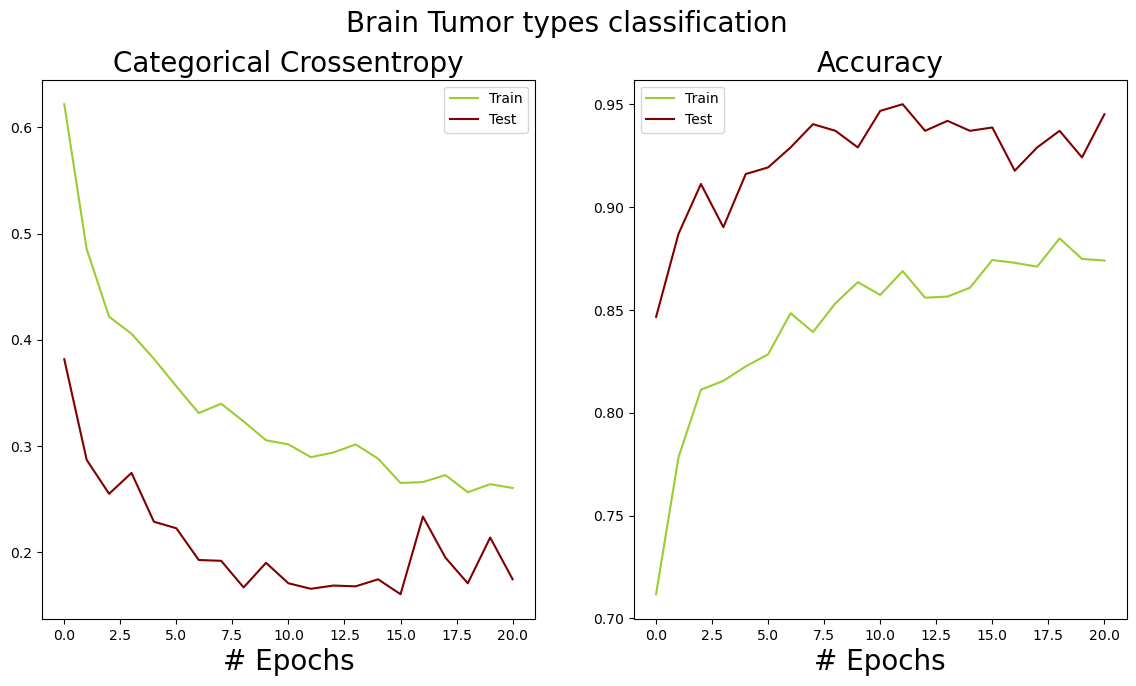

In [58]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_bt_aug, 'Brain Tumor types classification')

Accuracy_score: 0.9386 



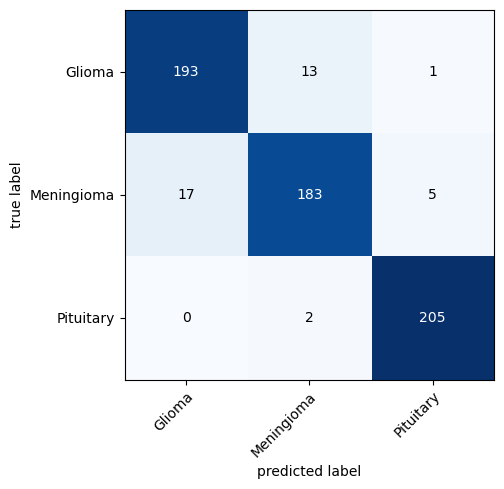

In [59]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_bt_aug, X=X_val_bt, y=y_val_bt, class_names_list = ['Glioma', 'Meningioma', 'Pituitary'])

Accuracy_score: 0.7578 



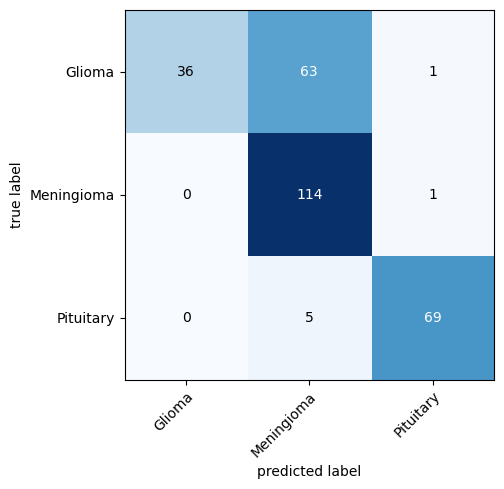

In [60]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_bt_aug, X=X_test_bt, y=y_test_bt, class_names_list = ['Glioma', 'Meningioma', 'Pituitary'])

In [61]:
# model_bt_aug.save('../models/model_bt_aug.hdf5') the models are too big for git (over 50 MB limit) you can see them in https://drive.google.com/drive/folders/1c6tiwYgU2JKSHqd8JnuYHc5rYQC3wRYI?usp=share_link

Augmentation improved the model accuracy in classifing Brain Tumor type from 71% to 76%.

---

## Combine all to classify a single input image

After evaluating the performance of models with and without augmentation for different tasks, I have found that the Disease/No Disease classification works better without augmentation, while Alzheimer's/Brain tumor classification perform great without augmentation. On the other hand, Alzheimer's severity and Brain tumor type classification work better with augmentation.

Based on these findings, I will combine my best models and create a function for classifying a single input image.

In [5]:
############## Only if you did not run models. ############## Downloads models from goodle drive. ##############

import gdown
def load_model_from_google_drive(link_to_file, model_name):
    '''
    inspired by https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
    Input: 
    link_to_file, str - link to the file in google drive (open the file in a new window and copy the id - everything after the last slash, put it after https://drive.google.com/uc?id=)
    model_name, str - the name of the model for saving on the disc with .hdf5 at the end
    Output: save models to the disc
    Return: TensorFlow model
    '''
    url = link_to_file
    output = model_name
    # download the model from google drive
    gdown.download(url, output, quiet=True)
    # load the model
    model = load_model(model_name)   
    return model

# Model predicting Disease or no Disease
model_aug = load_model_from_google_drive(link_to_file = 'https://drive.google.com/uc?id=1YmZyLpmM6FKjOgViibGTTHb1Jgz3spli', model_name = 'disease_no_disease_aug.hdf5')        
# Model predicting Ailzheimer's or Brain Tumor
model_al_bt = load_model_from_google_drive(link_to_file = 'https://drive.google.com/uc?id=1nEG_DJ3JALKz1Ylv40z_b22eEpatjM9K', model_name = 'al_bt.hdf5') 
# Predict Severity of alzheimer's disease
model_al_aug = load_model_from_google_drive(link_to_file = 'https://drive.google.com/uc?id=12n6XMrG1LN26x8R_HaHnm-vvAKrATm4b', model_name = 'model_al_aug.hdf5')
# Predict Brain Tumor Type
model_bt_aug = load_model_from_google_drive(link_to_file = 'https://drive.google.com/uc?id=1GE1y3dyLTrnUHrPWdjK117AyF0u-YBdJ', model_name = 'model_bt_aug.hdf5')

############## Only if you did not run models. ############## Downloads models from goodle drive. ##############

In [6]:
def preprosses_image(image_path):
    '''
    Preprosses a single image for TensorFlow predictions.
    Input: image_path - string, path to the single image
    Return: image converted to array
    '''
    test_img = load_img(image_path, target_size=(image_size, image_size), color_mode='grayscale') # Read grayscale image and set size 
    test_img = expand_dims(test_img, -1) # Change from (image_size, image_size) to (image_size, image_size, 1)
    test_img = grayscale_to_rgb(test_img) # Change from (image_size, image_size, 1) to (image_size, image_size, 3) adding the same data to all channels
    test_img = img_to_array(test_img) 
    test_img = expand_dims(test_img, 0) # Change to (1, image_size, image_size, 3) for TensorFlow model 
    return test_img

In [7]:
def predict_image(image_path, output_for_function=False):
    '''
    Predicting disease on a single image using combined models Disease or No Disease, Alsheimer\'s or Brain tumor, Severity of Alzheimer's or Type of Brain tumor
    Input: 
    image_path - string, path to the single image
    output_for_function - bool, controls returns, if True returns indexes of labels, otherwise returns strings with classification, default - False
    Return: classification - if output_for_function=False string, classification from combined models 
                           - if output_for_function=True integer, class index from combined models 
    '''
    # Prepare image for TensorFlow models
    test_img = preprosses_image(image_path)
    # Predict Disease (1) or No Disease (0)
    pred_dis = (model_aug.predict(test_img, verbose = False) > 0.5).astype("int32")
    if pred_dis[0][0] == 0:
        if output_for_function:
            return 2 # Combine both No Disease labels the same as in predict_images_from_path
        else:
            return 'No disease found in MRI'
    else:
        # Predict Alzheimer's (0) or Brain tumor(1)
        predict_al_bt = (model_al_bt.predict(test_img, verbose = False) > 0.3).astype("int32")
        if predict_al_bt[0][0] == 0:
            # Predict severity of the Alzheimer's
            predict_al = model_al_aug.predict(test_img, verbose = False).argmax(axis=1)[0]
            if output_for_function:
                if predict_al == 2: # Account for absense of NonDemented
                    predict_al = 3
                return predict_al
            else:
                al_list = ['Mild', 'Moderate', 'Very Mild']
                return f'{al_list[predict_al]} Alzheimer\'s'
        else:
            # Predict type of brain tumor
            predict_bt = model_bt_aug.predict(test_img, verbose = False).argmax(axis=1)[0]
            if output_for_function:
                return predict_bt + 4
            else:
                bt_list = ['Glioma', 'Meningioma', 'Pituitary']
                return f'{bt_list[predict_bt]} Brain Tumor'  

In [11]:
# Predict image from Alzheimer test data
predict_image('../data/alzheimer/test/MildDemented/27 (25).jpg')

"Mild Alzheimer's"

In [12]:
# Predict image from Brain Tumor test data
predict_image('../data/brain_tumor/test/meningioma_tumor/image(2).jpg')

'Meningioma Brain Tumor'

In [13]:
# Predict image from No disease
predict_image('../data/brain_tumor/test/no_tumor/image(10).jpg')

'No disease found in MRI'

---

## Evaluete the model on all test images

In [14]:
def predict_images_from_path(path):
    '''
    Predict each image from the path using my final prediction from a single image function 
    Input: 
    path - str, the path to the images
    Return: 
    predictions - list, index of predicted label - all non-disease - 2, brain tumor label numbers after Alzheimer's
    labels_num - list, label numbers - all non-disease - 2, brain tumor label numbers after Alzheimer's
    '''
    predictions = []
    labels_num = []
    
    # Labels from the folder names
    for num_label, label in enumerate(listdir(path)):
        # Change each image and append to X and y
        for image in listdir(f'{path}/{label}'):
            if '.jpg' in image:
                # Make prediction on the single image
                prediction = predict_image(f'{path}/{label}/{image}', output_for_function = True)
                predictions.append(prediction)
                
                # Get labels indexes, add 4 to brain tumor indexes, to put them after Alzheimers
                if label in ('NonDemented', 'no_tumor'):
                    labels_num.append(2)  # Combine both No Disease labels
                elif label == 'pituitary_tumor': 
                    labels_num.append(num_label+3) # Account for absense of no_tumor
                elif 'brain_tumor' in path: 
                    labels_num.append(num_label+4) # Brain Tumor index after Alzheimer's indexes
                else:
                    labels_num.append(num_label)
               
    return predictions, labels_num

In [15]:
def all_test(path1, path2):
    '''
    Combine predictions and lables from two paths
    Input: 
    path1 - str, the path to first the images folder
    path2 - str, the path to second the images folder
    Return:
    predictions - list, conbined from two paths index of predicted label - all non disease - 2, brain tumor lable numbers after alzheimers
    labels_num - list, conbined from two paths lable numbers - all non disease - 2, brain tumor lable numbers after alzheimers
    '''
    predictions_1, labels_1 = predict_images_from_path(path1)
    predictions_2, labels_2 = predict_images_from_path(path2)
    
    predictions = predictions_1 + predictions_2
    labels = labels_1 + labels_2

    return predictions, labels

In [16]:
def acc_conf_matrix_from_predictions(predictions, labels, class_names_list):
    '''
    Evaluate the model 
    Input:
    predictions - list, conbined from two paths index of predicted label - all non disease - 2, brain tumor lable numbers after alzheimers
    labels_num - list, conbined from two paths lable numbers - all non disease - 2, brain tumor lable numbers after alzheimers   
    Output:
    Prints Accuracy of the model on a given set of data
    Plots Confusion matrics for a given set of data
    '''
    # Generate Confusion Matrix    
    cm = confusion_matrix(labels=labels, predictions=predictions).numpy()
    # Print Accuracy score
    acc = round(accuracy_score(labels, predictions), 4)
    print(f'Accuracy_score: {acc} \n') 
    # Plot the confusion matrix
    fig, ax = plot_confusion_matrix(cm, class_names=class_names_list, figsize=(10, 10))
    ax.set_xlabel('Predicted label', fontsize=16)
    ax.set_ylabel('True label', fontsize=16)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)

    # Save for the presentation
    plt.tight_layout()
    plt.savefig('../images/final_app_cm.jpeg');

In [17]:
# Names of the classes ordered as they are indexed in the function.
class_names_list = ['Mild Demented', 'Moderate Demented', 'No Disease', 'Very Mild Demented', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']

---

In [46]:
# Get predictions and labels for all test images
predictions, labels = all_test(al_path_test, bt_path_test)

Accuracy_score: 0.6958 



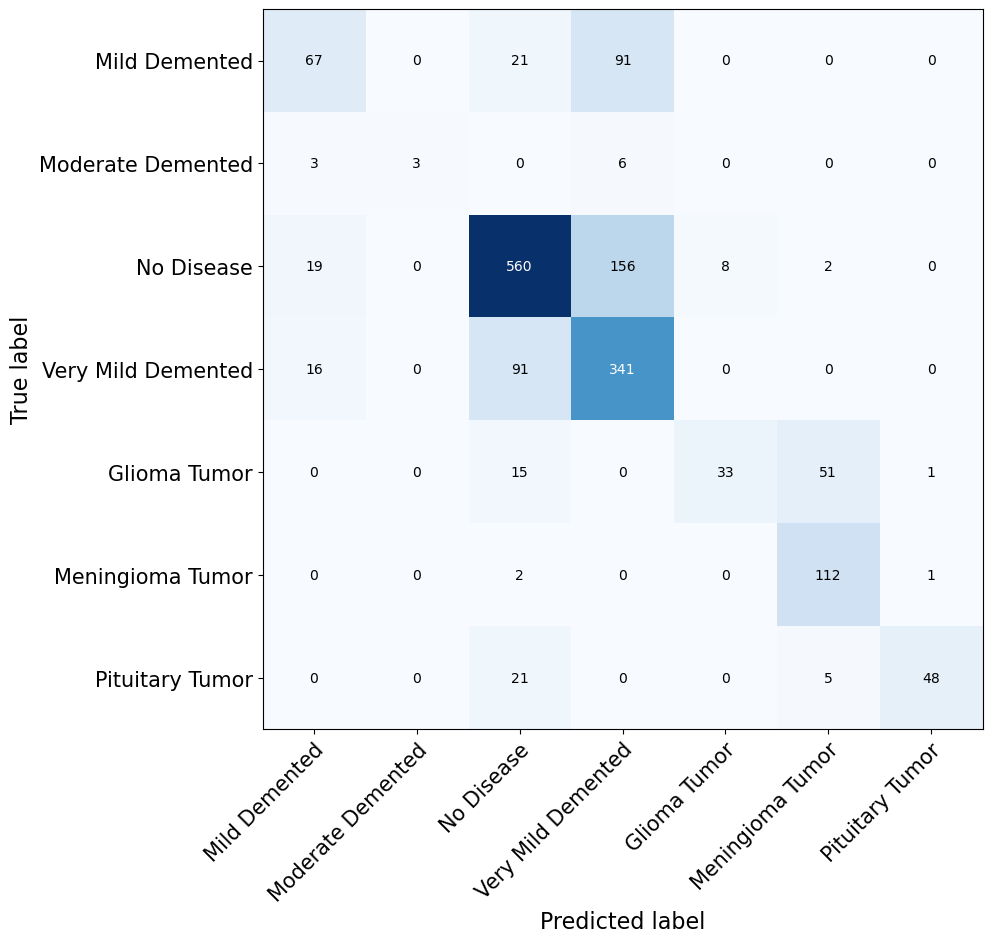

In [47]:
# Evaluete my final model
acc_conf_matrix_from_predictions(predictions, labels, class_names_list)

My model still struggles to differentiate Alzheimer's severity and Glioma tumor.

---

## Streamlit app
Based on the results of the trained models, I selected the best performing models for each disease classification and used them to develop a Streamlit application capable of classifying a single input image. The user can upload an image, and the app displays the image and predicts the class label and corresponding probability using the pre-trained models.
[My Streamlit app](https://ailinnesse-mri-disease--codestreamlit-mri-classification-om06bb.streamlit.app/)

---

## Conclusion:
I have developed  an application that can classify individual brain MRI images and significantly improved on the baseline accuracy of 37%. The application can be a valuable initial tool for medical professionals to analyze MRI images, particularly in the case of meningioma tumors, which are often miscassified by medical professionals.